In [9]:
# Pipeline (first cell)

from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data.sentdex import sentiment
import numpy as np

def make_pipeline():
    base_universe = QTradableStocksUS()
        
    stocktwits_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    ).zscore()
    
    sentdex_score = SimpleMovingAverage(
        inputs = [sentiment.sentiment_signal],
        window_length = 3,
    ).zscore()
    
    combined_score = (stocktwits_score + sentdex_score) / 2

    # Create filter for top 350 and bottom 350
    # assets based on their sentiment scores
    top_bottom_scores = (
        combined_score.top(350) | combined_score.bottom(350)
    )

    return Pipeline(columns={
        'combined_score': combined_score
        })


def make_pipeline_crossover():
    base_universe = QTradableStocksUS()
        
    stocktwits_score = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear],window_length=1,)
    stocktwits_cross = SimpleMovingAverage(inputs=[stocktwits.bull_minus_bear],window_length=20,)
    stocktwits_final = (stocktwits_score - stocktwits_cross).zscore()
    
    sentdex_score = SimpleMovingAverage(inputs = [sentiment.sentiment_signal], window_length = 1,)
    sentdex_cross = SimpleMovingAverage(inputs = [sentiment.sentiment_signal], window_length = 20,)
    sentdex_final = (sentdex_score - sentdex_cross).zscore()
    
    combined_score = (stocktwits_final + sentdex_final) / 2

    # Create filter for top 350 and bottom 350
    # assets based on their sentiment scores
    top_bottom_scores = (
        combined_score.top(350) | combined_score.bottom(350)
    )

    return Pipeline(columns={
        'combined_score': combined_score
        })


my_pipe = make_pipeline_crossover()

pipeline_data = run_pipeline(my_pipe, start_date='2014-1-1', end_date='2016-1-1').dropna()

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-3.657505,-0.397928,-1.078588,0.418851,53650,20.079269
2,-0.789476,-0.057006,-0.374898,0.125004,53318,19.955013
3,-0.323835,0.325897,-0.040471,0.106942,53331,19.959879
4,-0.026151,0.854400,0.382708,0.171892,53311,19.952394
5,0.409775,4.124394,1.107175,0.397894,53581,20.053445


Returns Analysis


,1D,5D,10D
Ann. alpha,0.030,0.023,0.010
beta,0.005,0.007,0.001
Mean Period Wise Return Top Quantile (bps),1.500,0.996,0.722
Mean Period Wise Return Bottom Quantile (bps),-1.436,-1.004,-0.130
Mean Period Wise Spread (bps),2.936,2.001,0.855


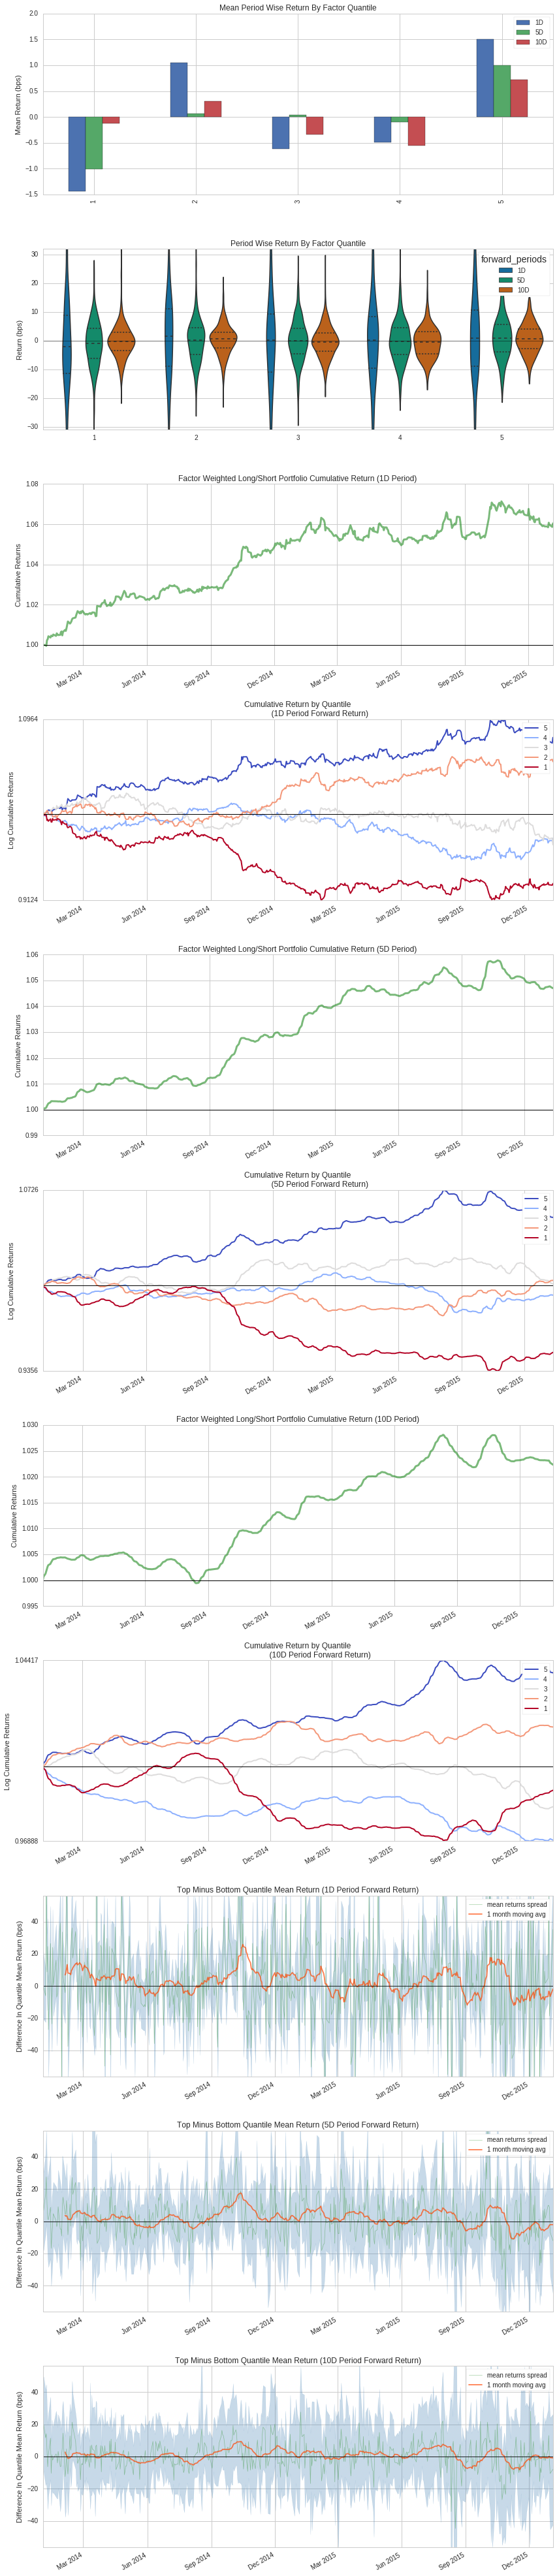

Information Analysis


,1D,5D,10D
IC Mean,0.003,0.005,0.001
IC Std.,0.047,0.048,0.046
Risk-Adjusted IC,0.065,0.098,0.020
t-stat(IC),1.456,2.194,0.447
p-value(IC),0.146,0.029,0.655
IC Skew,0.043,0.037,0.032
IC Kurtosis,0.281,-0.042,0.048


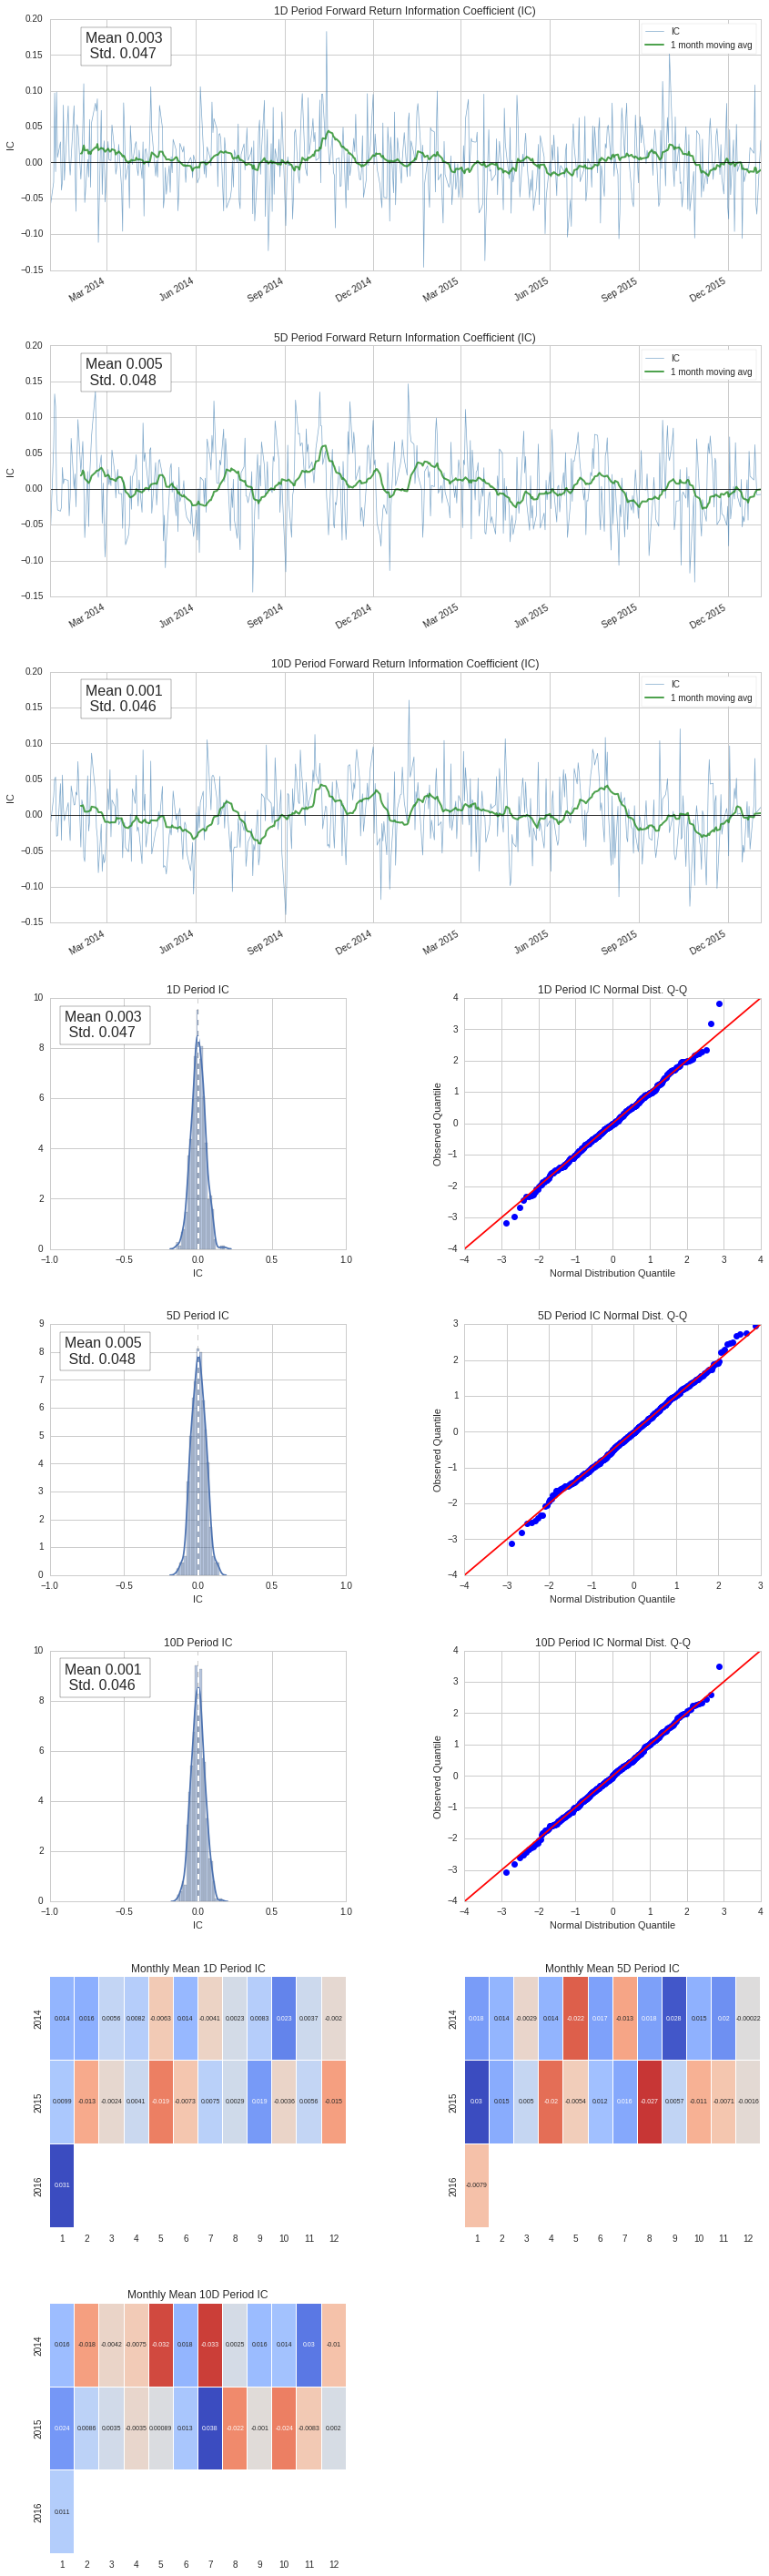

Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.790,0.517,0.705
Quantile 2 Mean Turnover,0.784,0.572,0.734
Quantile 3 Mean Turnover,0.756,0.560,0.707
Quantile 4 Mean Turnover,0.794,0.624,0.759
Quantile 5 Mean Turnover,0.802,0.551,0.734


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.418,0.133,-0.018


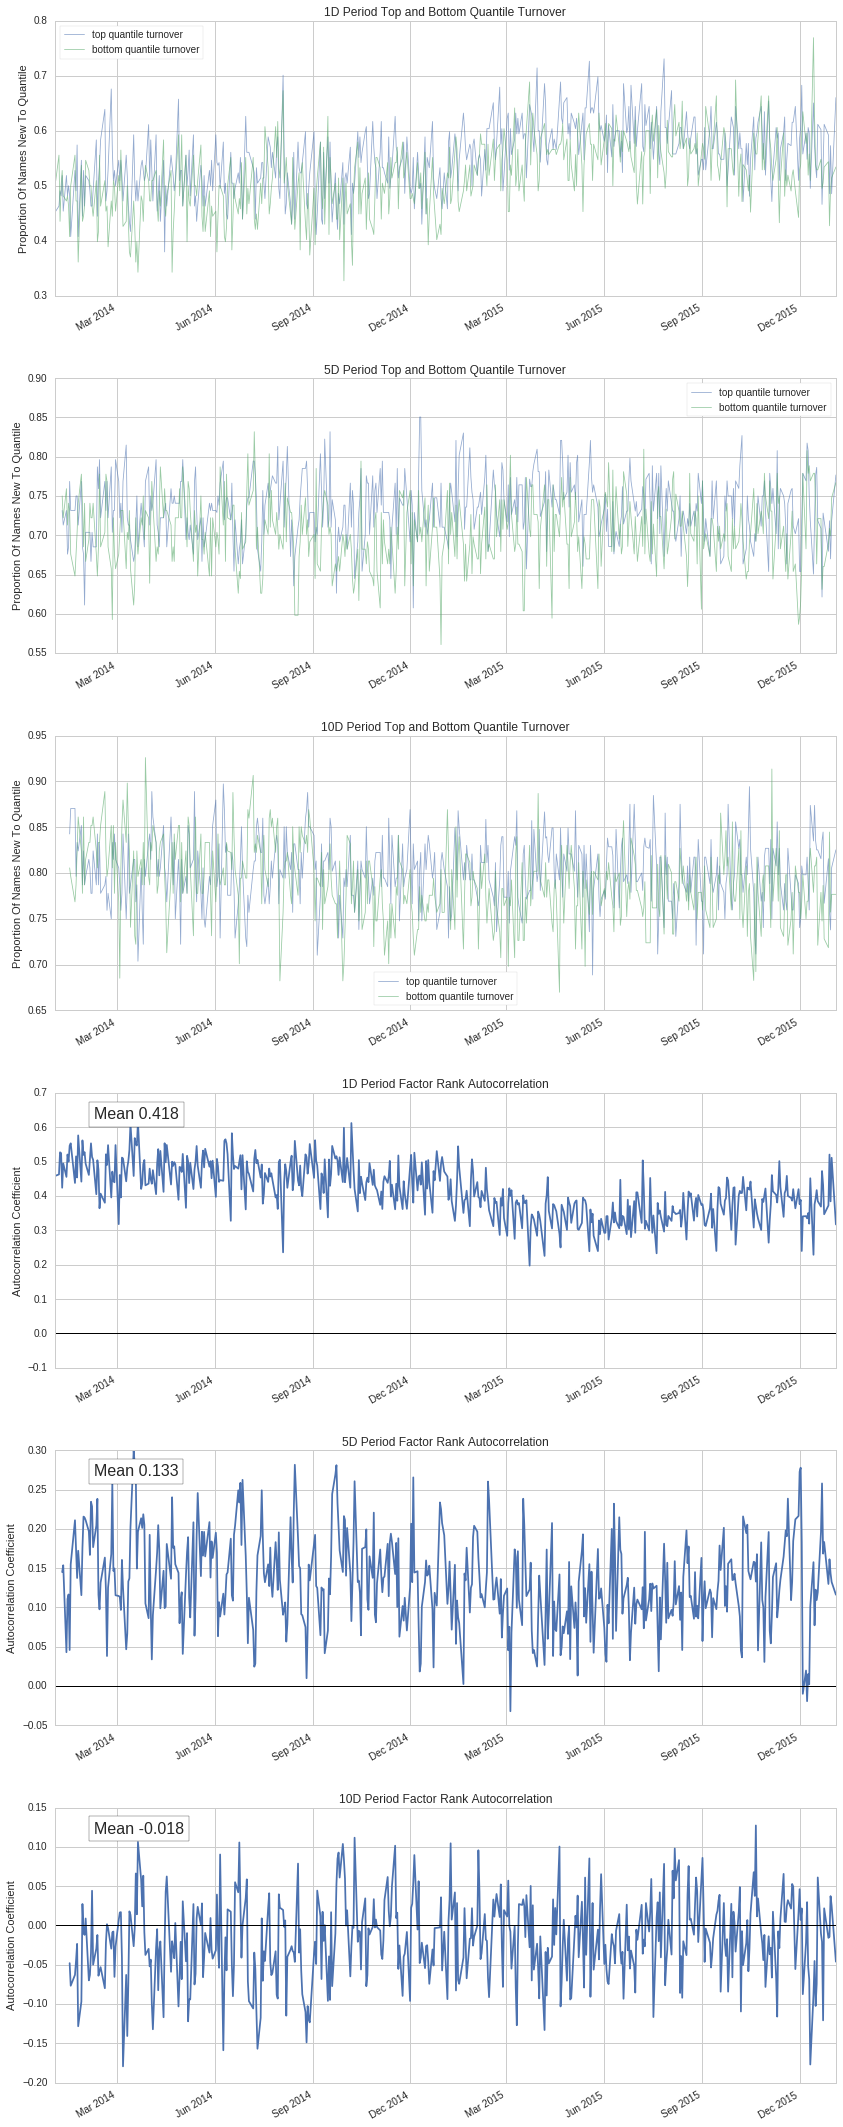

In [10]:
# Alphalens (second cell)

from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet


pricing_data = get_pricing(
  symbols=pipeline_data.index.levels[1], # Finds all assets that appear at least once in the pipeline
  start_date='2014-1-1',
  end_date='2016-2-1', #1 trading day after end date of pipeline
  fields='open_price'
)

merged_data = get_clean_factor_and_forward_returns(
  factor=pipeline_data['combined_score'],
  prices=pricing_data
)

create_full_tear_sheet(merged_data)